In [2]:
############### Toate functiile #################

In [116]:
import numpy as np
from skimage import io, color, measure
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt
import math
import os 
from skimage.transform.integral import integral_image

In [ ]:
#######################################################################################
######################################## LAB 1 ######################################## Peer et al (detecteaza fete)
#######################################################################################

In [ ]:
# General functions 
img=io.imread(r'C:\Users\maria\Documents\GitHub\Labs-IVOM\Lab - 6 HOG\Mari\BioID_F1_1.jpg')
img_gray = color.rgb2gray(img)
[L, C] = np.shape(img_gray)

plt.figure(), plt.imshow(img, cmap = 'gray'),plt.colorbar(), plt.show()


In [121]:
# rgb2gray
def rgb2gray(img):
    """
    Convert an RGB image to grayscale.
    """
    
    return np.uint8(255*color.rgb2gray(img))

In [122]:
# histograma
def histograma(img):
    """
    Compute the histogram of an image.
    """
    
    hist, _ = np.histogram(img, bins=256, range=(0, 255))
    plt.figure(), plt.plot(hist), plt.show()
    return hist

In [123]:
def my_precrec(MASK, SEGM):
    
    epsilon=0.00001

    TN = (1-SEGM)*(1-MASK)
    TP=SEGM*MASK
    FP=SEGM*(1-MASK)
    FN=(1-SEGM)*MASK

    TN_proc = np.sum(TN)/np.size(MASK)
    TP_proc=np.sum(TP)/np.size(MASK)
    FP_proc=np.sum(FP)/np.size(MASK)
    FN_proc=np.sum(FN)/np.size(MASK)

    prec=np.sum(TP)/(np.sum(TP)+np.sum(FP)+epsilon)
    rec=np.sum(TP)/(np.sum(TP)+np.sum(FN)+epsilon)

    return TN_proc, TP_proc, FP_proc, FN_proc, prec, rec

In [124]:
def praguire_img(img, nr_praguri, T, T1, T2):
    """
    Apply thresholding to an image.
    """
    
    if nr_praguri == 1:
        img_out = img < T
    elif nr_praguri == 2:
        img_gray = np.uint8(255*color.rgb2gray(img))
        img_out = (img_gray > T1) & (img_gray < T2)

    return img_out

In [125]:
# Alg Peer et al pentru detectia fetei
def peer_et_al(img):
    """
    Detect faces in an image using the Peer et al. method.
    """

    L,C,pl = np.shape(img)
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    C1 = (R > 95) & (G > 40) & (B > 20)
    C2 = (np.max([R,G,B]) - np.min([R,G,B]) > 15)
    C3 = np.abs(R-G) > 15
    C4 = (R > G)&(R > B)
    C5 = (R > 220)&(G > 210)&(B > 170)
    C6 = np.abs(R-G) <= 15
    C7 = (R > B)&(G > B)
    
    img_out = (C1*C2*C3*C4) + (C5*C6*C7)
    img_out[img_out>0] = 1

    img_out3 = praguire_img(img, nr_praguri=1, T=75, T1=100, T2=175)
    TN, TP, FP, FN, prec, rec = my_precrec(img_out3, img_out)
    
    plt.figure(), plt.imshow(img_out3, cmap = 'gray'),plt.colorbar(), plt.show()
    print(f"TN = {TN}\n TP = {TP}\n FP = {FP}\n FN = {FN}\n prec = {prec}\n rec = {rec}")

    return img_out3


In [ ]:
##########################################################################################
####################################### LAB 2 ############################################ Viola Jones (img integ + suma_dreptunghi)
##########################################################################################

In [ ]:
# functia care calculeaza imaginea integrala
def img_integrala(img, variant):
    L,C = np.shape(img)
    img_out = np.zeros((L,C))
    if variant == 1:
        img_out = np.cumsum(np.cumsum(img,axis=1), axis=0)
        return img_out
    elif variant == 2:
        for i in range(0,L):
            for j in range(0,C):
                if i==0 and j==0:
                    img_out[i,j] = img[i,j]
                elif i==0 and j!=0:
                    img_out[i,j] = img[i,j] + img_out[i,j-1]
                elif i!=0 and j==0:
                    img_out[i,j] = img[i,j] + img_out[i-1,j]
                elif i!=0 and j!=0:
                    img_out[i,j] = img[i,j] + img_out[i,j-1] + img_out[i-1,j] - img_out[i-1,j-1]
        return img_out

In [ ]:
#calcul dreptunghi din img_integ (suma de pixeli din orice dreptunghi din img initiala)
def suma_dreptunghi(poz_i, poz_j, h_fer, w_fer, img_integrala):
    A=0
    B=0
    C=0
    D=0
    if poz_i==0 and poz_j==0:
        D = img_integrala[poz_i+h_fer-1, poz_j+w_fer-1]
    elif poz_i==0 and poz_j!=0:
        C = img_integrala[poz_i+h_fer-1, poz_j-1]
        D = img_integrala[poz_i+h_fer-1, poz_j+w_fer-1]
    elif poz_i!=0 and poz_j==0:
        B = img_integrala[poz_i-1,poz_j+w_fer-1]
        D = img_integrala[poz_i+h_fer-1, poz_j+w_fer-1]
    elif poz_i!=0 and poz_j!=0:
        A = img_integrala[poz_i-1,poz_j-1]
        B = img_integrala[poz_i-1,poz_j+w_fer-1]
        C = img_integrala[poz_i+h_fer-1, poz_j-1]
        D = img_integrala[poz_i+h_fer-1, poz_j+w_fer-1]
    
    sum = A+D-B-C
    return sum

In [ ]:
##########################################################################################
################################# Ccontinuare lab 2 Lee ################################## Lee
##########################################################################################

In [129]:
# filtrul LEE (folosind img integrala) pt zgomot gaussian
def filt_LEE(w_size, h_img, w_img, img_integrala, img_integrala_la_patrat, noise_var, img_denoise):
    
    #PARAMETRII : capat,dim ferestrei,dim imaginii,img_integ pt imaginea init
    #             img_integ pt img_init la patrat, copie a imaginii initiale
    #             pt a calcula noile valori filtrate

    capat = math.floor(w_size/2)

    #RETURN img filtrata(img_denoise)
    #parcurgem imaginea si "plimbam" feresetrele
    for i in range(capat,h_img-capat):
        for j in range(capat,w_img-capat):

            # ecuatia filtrului : I_out=alpha * I_med + (1-alpha) * I
            # unde I_out - noua valoare a pixelului filtrat
            #      alpha = sqrt (noise_var/fer_var) [0,1]
            #      I_med = media pixelilor din fereastra
            #      I = pixelul original din imaginea curenta
            #      fer_var=I**2_med - I_med**2

            # zona uniforma => alpha ~ 1 => I_new = I-med
            # zona cu detaliu => alpha ~ 0 => I_new ~ I
            # var_fer = (I^2)_med - I_med^2
            # calculez I_med**2(media pixelilor din ferastra la patrat)
            # folosind functia suma_dreptungi(dreptunghiul e fiec fereastra)
            img_med=suma_dreptunghi(i-capat, j-capat, w_size, w_size, img_integrala) / (w_size**2)
            img_med_patrat=img_med**2
            
            # calculez I**2_med(media pixelilor ridicati la patrat din ferastra )
            img_patrat_med= suma_dreptunghi(i-capat, j-capat, w_size, w_size, img_integrala_la_patrat) / (w_size**2)
            
            #calculez varianta ferestrei fer_var
            fer_var= img_patrat_med - img_med_patrat
            
            #ma asigur ca varianta din fereastra nu e mai mare ca cea a zg
            #altfel ar exista unele sanse ca alpha sa fie > 1, dar el apartine [0,1]
            fer_var = max(fer_var,noise_var)
            
            #calculez alpha conform formulei cu radical
            alpha = np.sqrt(noise_var/fer_var) 
            
            #calculez noua valoare a pixelului filtrat
            img_denoise[i,j] = img_med*alpha + img_denoise[i,j]*(1-alpha)
  
    return img_denoise

# noise_var = img_gray[:10, :10].var() # o portiune mai uniforma din imagine
# img_denoise = img_Lee.copy()
# img_integrala_la_patrat = img_integrala(img_gray**2, method=1)
# img_integrala = img_integrala(img_gray, method=1)

In [130]:
# filtrul LEE (folosind img integrala)
def filt_LEE_V2(capat, size, h, w, noise_var, img_integ, img_integ_sq, img_denoise):
    for i in range(capat, h - capat):
        for j in range(capat, w - capat):
            img_mean = suma_dreptunghi(i - capat, j - capat, size, size, img_integ) / (size * size)
            img_mean_sq = img_mean ** 2
            img_sq_mean = suma_dreptunghi(i - capat, j - capat, size, size, img_integ_sq) / (size * size)
            fer_var = img_sq_mean - img_mean_sq
            fer_var = max(fer_var, noise_var)
            alpha = np.sqrt(noise_var / fer_var)
            img_denoise[i, j] = alpha * img_mean + (1 - alpha) * img_denoise[i, j]
    return img_denoise

# noise_var = img_gray[:10, :10].var() # o portiune mai uniforma din imagine
# img_denoise = img_Lee.copy()
# img_integ_sq = img_integrala(img_gray**2, method=1)
# img_integrala = img_integrala(img_gray, method=1)

In [ ]:
img = io.imread('noise_img1.jpg')
img_gray = color.rgb2gray(img)
[L, C] = np.shape(img_gray)

img_Lee = io.imread('noise_img1.jpg')
img_Lee = color.rgb2gray(img_Lee)
plt.figure(),plt.imshow(img_Lee,cmap='gray')

noise_var = img_gray[:10, :10].var() # o portiune mai uniforma din imagine
img_denoise = img_Lee.copy()
img_integ_sq = img_integrala(img_gray**2, method=1)
size = 3
capat = size // 2
img_denoise = filt_LEE_V2(capat, size, L, C, noise_var, img_integ_sq, img_integ_sq, img_denoise)

In [ ]:
##########################################################################################
####################################### LAB 3 ############################################ haar
##########################################################################################

In [ ]:
# H1,2 - orizonatala 0 1 (Za Zn)
# H2,2 - verticala 1
#                  0
# H3 - 1 0 1 
# H4 - 0 1
#      1 0

In [132]:
def haar_unu(l_start,c_start,h_tras,w_tras,img_integrala):
    
    # [za] [zn]
    
    #PARAMETERS: pozitia pixelului din coltul st-sus (l,c), dim dreptunghiului(h,w), img_integ
    # RETURN (zonele negre,zonele albe, catacteristica propriu-zisa)
    zona_neagra = suma_dreptunghi(l_start,c_start+w_tras//2,h_tras,w_tras//2,img_integrala)
    zona_alba   = suma_dreptunghi(l_start,c_start,h_tras,w_tras//2,img_integrala)
    H1          = zona_alba - zona_neagra
    
    return zona_alba, zona_neagra, H1

In [ ]:
def haar_doi(l,c,h,w,img_integrala):
    
    # [za] 
    # [zn]
    
    #PARAMETERS: pozitia pixelului din coltul st-sus (l,c), dim dreptunghiului(h,w), img_integ
    # RETURN (zonele negre,zonele albe, catacteristica propriu-zisa)
    zona_neagra = suma_dreptunghi(l,c,h//2,w,img_integrala)
    zona_alba   = suma_dreptunghi(l+h//2,c,h//2,w,img_integrala)
    H2          = zona_alba - zona_neagra
    
    return zona_alba, zona_neagra, H2

In [135]:
def haar_trei(l,c,h,w,img_integrala):
    
    # [zn] [za] [zn]
    
    #PARAMETERS: pozitia pixelului din coltul st-sus (l,c), dim dreptunghiului(h,w), img_integ
    # RETURN (zonele negre,zonele albe, catacteristica propriu-zisa)
    zona_neagra_1  = suma_dreptunghi(l,c,h,w//3,img_integrala)
    zona_neagra_2  = suma_dreptunghi(l,c+2*w//3,h,w//3,img_integrala)
    zona_alba      = suma_dreptunghi(l,c+w//3,h,w//3,img_integrala)
    H3             = zona_alba - zona_neagra_1 - zona_neagra_2
    
    return zona_neagra_1, zona_neagra_2, zona_alba, H3

In [136]:
def haar_patru(l,c,h,w,img_integrala):
    
    # [za] [zn] 
    # [zn] [za] 
    
    #PARAMETERS: pozitia pixelului din coltul st-sus (l,c), dim dreptunghiului(h,w), img_integ
    # RETURN (zonele negre,zonele albe, catacteristica propriu-zisa)
    
    zona_neagra_1 = suma_dreptunghi(l,c+w//2,h//2,w//2,img_integrala)
    zona_neagra_2 = suma_dreptunghi(l+h//2,c,h//2,w//2,img_integrala)
    zona_alba_1   = suma_dreptunghi(l,c,h//2,w//2,img_integrala)
    zona_alba_2   = suma_dreptunghi(l+h//2,c+w//2,h//2,w//2,img_integrala)
    H4            = zona_alba_1+ zona_alba_2 - zona_neagra_1 - zona_neagra_2
  
    return zona_neagra_1, zona_neagra_2, zona_alba_1, zona_alba_2, H4

In [ ]:
def haar_T(l, c, h, w, img_integ):
    # [za] [zn] [za]
    # [  ] [zn] [  ]

    zona_alba_1 = suma_dreptunghi(l, c, h//2, w//3, img_integ)
    zona_neagra_1 = suma_dreptunghi(l, c + w//3, h//2, w//3, img_integ)
    zona_alba_2 = suma_dreptunghi(l, c + 2*w//3, h//2, w//3, img_integ)
    zona_neagra_2 = suma_dreptunghi(l + h//2, c + w//3, h//2, w//3, img_integ)
    HT = zona_alba_1 + zona_alba_2 - zona_neagra_1 - zona_neagra_2

    return zona_neagra_1, zona_neagra_2, zona_alba_1, zona_alba_2, HT

In [ ]:
def haar_3V(l,c,h,w,ii):

    # [za1] [zn] [za2]
    
    #PARAMETERS: pozitia pixelului din coltul st-sus (l,c), dim dreptunghiului(h,w), img_integ
    # RETURN (zonele negre,zonele albe, catacteristica propriu-zisa)
    zona_neagra= suma_dreptunghi(l+h//3, c, h//3, w, ii)
    zona_alba_1= suma_dreptunghi(l, c, h//3, w, ii)
    zona_alba_2= suma_dreptunghi(l+2*h//3, c, h//3, w, ii)
    H_3V= zona_alba_1 + zona_alba_2 - zona_neagra
    
    return(zona_neagra,zona_alba_1,zona_alba_2,H_3V)

In [ ]:
def H_L(l,c,h,w,img_integ):

     # [   ] [zn1] [   ]
     # [za2] [   ] [za1]
     # [   ] [zn1] [   ]

     zn1=suma_dreptunghi(l,c,h,w//3,img_integ)
     za2=suma_dreptunghi(l,c-w//3,h,w//3,img_integ)
     za1=suma_dreptunghi(l,c+w//3,h,w//3,img_integ)
     zn2=suma_dreptunghi(l+h,c+w//3,h,w//3,img_integ)
     haar=za1+za2-zn1-zn2
     
     return zn1,zn2,za1,za2,haar

In [ ]:
###############################################################################
######################### Lab 4 (continuare lab 3) ############################ (optional)
###############################################################################

In [ ]:
#functie pentru caluclul performnatei tp,tn,fp,fn
def performanta(predictie_haar, ref):
    
    nr_imagini_nonfete = 10
    nr_imagini_fete = 10 # DE MODIFICAT
    #Parameters : etichete_referinta, trasaturi_haar, nr_poze
    tp= np.logical_and(predictie_haar==1, ref==1).sum()/nr_imagini_fete
    fn= np.logical_and(predictie_haar==0, ref==1).sum()/nr_imagini_fete
    tn= np.logical_and(predictie_haar==0, ref==0).sum()/nr_imagini_nonfete
    fp= np.logical_and(predictie_haar==1, ref==0).sum()/nr_imagini_nonfete

    print(tp,fn,tn,fp)

In [ ]:
def calc_lista_haar_poze(path_poze):

    # path_poze = r"C:\Users\maria\Documents\GitHub\Labs-IVOM\Lab3-Haar features\lab3ivom\Mici"
    poze = os.listdir(path_poze)

    lista_haar = []

    for poza in poze:

        #citeste imagine si transforma in gray
        im=io.imread(path_poze+ "/" +poza)
        im = color.rgb2gray(im)
        
        #calculeaza imaginea integrala pt fiecare poza
        ii=integral_image(im)

        #calculeaza 2 variuante de trasaturi haar 
        zn1,zn2,za1,haar3=haar_trei(0,0,6,24,ii) # DE MODIFICAT POATE
        zn1,za1,haar2=haar_doi(0,6,12,12,ii)
        
        #adauga in lista valoarea trasaturii pt fiec poza
        lista_haar.append(haar3)

    lista_haar_array=np.asarray(lista_haar)

    return lista_haar_array

['face0.jpg', 'face1.JPG', 'face2.JPG', 'face3.JPG', 'face4.JPG', 'face5.jpg', 'face6.jpg', 'face7.jpg', 'face8.jpg', 'face9.jpg', 'false0.jpg', 'false1.jpg', 'false2.jpg', 'false3.jpg', 'false4.jpg', 'false5.jpg', 'false6.jpg', 'false7.jpg', 'false8.jpg', 'false9.jpg']
[-17.09019608 -18.53766275 -11.88123961  -8.95698078 -13.1245098
  -6.92717059 -11.04840549  -9.09716784 -18.5187102  -17.31764706
 -17.45461333 -15.35918118 -28.25866118 -30.88649647 -43.82729647
 -17.97144039 -33.14411333 -24.33165059 -43.32872784 -27.65776431]
(20,)
1.0 0.0 0.7 0.3


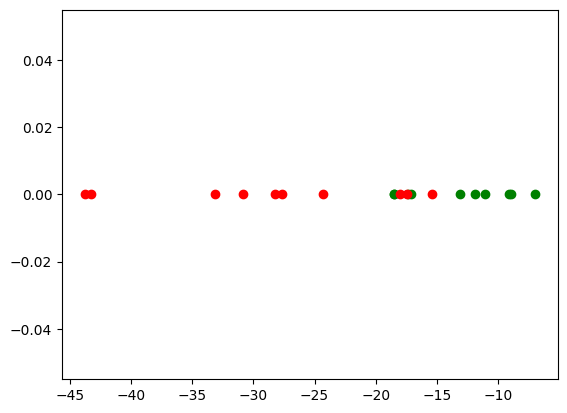

In [ ]:
path_poze = r"C:\Users\maria\Documents\GitHub\Labs-IVOM\Lab3-Haar features\lab3ivom\Mici"
poze = os.listdir(path_poze)
print(poze)

lista_haar_array = calc_lista_haar_poze(path_poze)
print(lista_haar_array)
print(np.shape(lista_haar_array))

# creeaza a doua axa pentru figura
nr_imagini = 20 # DE MODIFICAT DE AICI IN JOS
y = np.zeros(nr_imagini)

#ploteaza intr-o figura valorile haar pt fete cu verde si non-fete cu rosu
plt.figure() 
plt.scatter(lista_haar_array[0:10], y[0:10], color='g')
plt.scatter(lista_haar_array[10:20], y[10:20], color='r')

#alegeti pragul aastfel incat Tp max FP min
T= -20
ref = y
ref[0:10] = 1
pred_haar = (lista_haar_array > T)

#apelati fct de performanta 
performanta(pred_haar, ref)

In [ ]:
##########################################################################################
####################################### LAB 5 ############################################ LBP
##########################################################################################

In [141]:
#calculez descriptorul varianta lunga
def lbp(window):
    
    if window.shape != (3, 3):
        raise ValueError("The input matrix must be a 3x3 matrix.")
    
    center = window[1, 1]  # Center element

    # Extract edge elements in a clockwise manner
    edge_elements = [
        window[0, 0], window[0, 1], window[0, 2],  # Top row
        window[1, 2],                              # Right column
        window[2, 2], window[2, 1], window[2, 0],  # Bottom row (reversed)
        window[1, 0]                               # Left column
    ]
    #PARAMETERS: fereastra
    #RETURN: valoarea LBP asociata ferestrei
    
    #pun conditiile intre central si vecini
    lbp = [(1 if val >= center else 0) for val in edge_elements]

    #transform din binar in zecimal
    lbp_binary = ''.join(map(str, lbp))
    lbp_decimal = int(lbp_binary, 2)

    return edge_elements, lbp_binary, lbp_decimal

In [142]:
#varianta optimiazta de LBP
def lbp_optimizat(img):
    h, w = np.shape(img)
    I = []
    I_matrice = []

    # definirea celor 8 imagini shiftate
    I7 = img[0:h-2, 0:w-2]
    I.append(I7)
    I6 = img[0:h-2, 1:w-1]
    I.append(I6)
    I5 = img[0:h-2, 2:w]
    I.append(I5)
    I4 = img[1:h-1, 2:w]
    I.append(I4)
    I3 = img[2:h, 2:w]
    I.append(I3)
    I2 = img[2:h, 1:w-1]
    I.append(I2)
    I1 = img[2:h, 0:w-2]
    I.append(I1)
    I0 = img[1:h-1, 0:w-2]
    I.append(I0)

    Ic = img[1:h-1, 1:w-1]  

    for i in range(8):
        I_matrice.append(I[i] >= Ic)

    LBP = np.zeros_like(Ic, dtype=np.uint8)

 
    for i in range(8):
        LBP += (2**(7-i)) * I_matrice[i].astype(np.uint8)

    return LBP

Edge elements (clockwise): [np.int64(1), np.int64(2), np.int64(3), np.int64(6), np.int64(9), np.int64(8), np.int64(7), np.int64(4)]
LBP binary: 00011110
LBP decimal: 30


Text(0.5, 1.0, 'LBP Image')

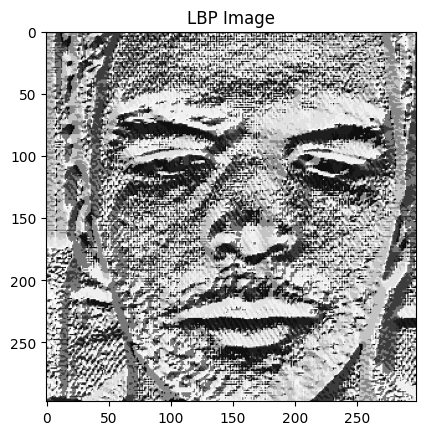

In [145]:
matrice = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

edge_elements, lbp_binary, lbp_decimal = lbp(matrice)

print("Edge elements (clockwise):", edge_elements)
print("LBP binary:", lbp_binary)
print("LBP decimal:", lbp_decimal)

###########################################################

img=io.imread(r'C:\Users\maria\Documents\GitHub\Labs-IVOM\Lab - 6 HOG\Mari\BioID_F1_1.jpg')
img = color.rgb2gray(img)  # Convert to grayscale if needed

lbp_img = lbp_optimizat(img)
plt.imshow(lbp_img, cmap='gray')
plt.title('LBP Image')

In [146]:
lbp_mask=np.array([[2,1,1,1,1,1,2],
    [2,4,4,1,4,4,2],
    [1,1,1,0,1,1,1],
    [0,1,1,0,1,1,0],
    [0,1,1,1,1,1,0],
    [0,1,1,2,1,1,0],
    [0,1,1,1,1,1,0]])

In [147]:
def eucdist(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2) ** 2))

In [ ]:
def calc_descriptori_lbp_poze(poze, path='Lab_5-LBP/Mari'):

    # poze = os.listdir('Mari')
    descriptori_lbp=np.zeros((len(poze),256*49)) # DE MODIFICAT (dim hist * dim mask)

    for k, poza in enumerate(poze):
        img = io.imread(os.path.join(path, poza))
        img = color.rgb2gray(img)  # Convert to grayscale if needed
        H, W = img.shape
        step = H//7 # DE MODIFICAT
        list_hist = []
        
        for i in range(0, H-step, step):
            for j in range(0, W-step, step):
                fer = img[i:i+step, j:j+step]
                lbp = lbp_optimizat(fer)
                hist = np.histogram(lbp, bins=256, range=(0, 256))[0] * lbp_mask[i//step, j//step]
                list_hist.append(hist)
        
        descr_lbp = np.array(list_hist)
        descriptori_lbp[k,:] = descr_lbp.flatten()

    return descriptori_lbp

In [149]:
def calc_distante_descriptori(descriptori):
    nr_imagini = descriptori.shape[0]
    distante = np.zeros((nr_imagini, nr_imagini))

    for i in range(nr_imagini):
        for j in range(i+1, nr_imagini):
            dist = eucdist(descriptori[i], descriptori[j])
            distante[i, j] = dist
            distante[j, i] = dist

    return distante

In [ ]:
def calc_nr_fete_similare_dist(distante):

    nr_fete=0

    calc_fete = np.argsort(distante)
    calc_fete_primele3coloane = np.sort(calc_fete[:,:3]) # DE MODIFICAT
    print(calc_fete_primele3coloane)

    posibile = ['012','345','678','91011'] # DE MODIFICAT DUPA NR DE POZE SIMILARE

    for i in range(calc_fete_primele3coloane.shape[0]):
        string = ''
        for j in range(3): # DE MODIFICAT
            string+= str(calc_fete_primele3coloane[i,j])
        if string in posibile:
            nr_fete += 1

    print("Nr. fete gasite din 12 = ", nr_fete) 
    print("Acuratetea =", (nr_fete/12)*100) # DE MODIFICAT
    print('Rata de clasificare ',nr_fete/12)

    return nr_fete

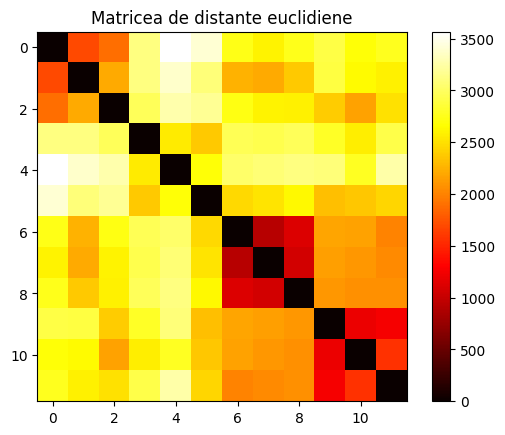

[[ 0  1  2]
 [ 0  1  2]
 [ 0  2 10]
 [ 3  4  5]
 [ 3  4  5]
 [ 5  9 10]
 [ 6  7  8]
 [ 6  7  8]
 [ 6  7  8]
 [ 9 10 11]
 [ 9 10 11]
 [ 9 10 11]]
Nr. fete gasite din 12 =  10
Acuratetea = 83.33333333333334
Rata de clasificare  0.8333333333333334


10

In [153]:
poze = os.listdir('Lab_5-LBP/Mari')

descriptori_lbp = calc_descriptori_lbp_poze(poze)

distante = calc_distante_descriptori(descriptori_lbp)

# afisez matricea de distante
plt.imshow(distante, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Matricea de distante euclidiene')
plt.show()

calc_nr_fete_similare_dist(distante)

In [ ]:
##########################################################################################
####################################### LAB 6 ############################################ HOG
##########################################################################################

In [ ]:
def hog(imagine, tip_nucleu, threshhold):

    #PARAMTERS: imagine,tip_nucleu, threshhold
    #RETURN: GV,GH,histograma gradientilor orientati
    h,w = np.shape(imagine)
    
    # calculul gradientilor Gh si GV in functie de fiecare nucleu
    if(tip_nucleu ==1):
        Gh = -imagine[0:h-2,:]+ imagine[2:h,:]
        Gv = -imagine[:,0:w-2] + imagine[:,2:w]
        
    if(tip_nucleu ==2):
        Gh = -imagine[0:h-1,:]+imagine[1:h,:]
        Gv = -imagine[:,0:w-1] + imagine[:,1:w] 
     
    if(tip_nucleu ==3): # DE MODIFICAT
        Gh = -imagine[0:h-2,0:w-2] + imagine[2:h,0:w-2] -2*imagine[0:h-2,1:w-1] + 2*imagine[2:h,1:w-1] - imagine[0:h-2,2:w] + imagine[2:h,2:w] 
        Gv = -imagine[0:h-2,0:w-2] + imagine[0:h-2,2:w] -2*imagine[1:h-1,0:w-2] + 2*imagine[1:h-1,2:w] - imagine[2:h,0:w-2] + imagine[2:h,2:w]
     
    # calcul magnitudine si orientare folosind Gh si Gv
    # puteti folosi math.sqrt si math.atan
    # daca folositi math.atan trebuie sa treceti din [-pi/2,i/2] in [0,pi]
    Mg = np.sqrt(Gh**2 + Gv**2)
    O = np.arctan(Gv/(Gh+0.001)) * (180 / math.pi) # DE MODIFICAT POATE
    
    #vectorizare magnitudine si gradienti\
    Mg = Mg.flatten()
    O = O.flatten()

    #anularea orientarilor pentru care magnitudinea este mai mica ca pragul ales
    # altfel spus vreau sa raman in vectorul de orientari doar cu pozitile valorilor
    # pentru care magnitudinea este mai mica decat T
    O[Mg < threshhold] = 1800
    O = O[O != 1800]

    #calculez histograma de orientari pt 9 bins cu np.histogram
    histograma = np.histogram(O, bins=9)[0] # DE MODIFICAT
    # print(histograma)

    #normez histograma la suma elementelor si adun si un epsilon ca sa
    #evit situatia in care impart la 0 (blocul contine o regiune uniforma)
    histograma = histograma / (np.sum(histograma) + 1e-5)
  
    return Gh, Gv, histograma

In [155]:
mask=np.array([[2,1,1,1,1,1,2],
    [2,4,4,1,4,4,2],
    [1,1,1,0,1,1,1],
    [0,1,1,0,1,1,0],
    [0,1,1,1,1,1,0],
    [0,1,1,2,1,1,0],
    [0,1,1,1,1,1,0]])

In [ ]:
def calc_descriptori_hog_poze(poze, path='Lab - 6 HOG/Mari'):

    # poze = os.listdir('Mari')
    descriptori_hog=np.zeros([len(poze),9*49]) # DE MODIFICAT nr_bins*nr_blocuri

    for k, poza in enumerate(poze):
        img = io.imread(os.path.join(path, poza))
        img = color.rgb2gray(img)  # Convert to grayscale if needed
        H,W=np.shape(img)
        step = math.ceil(img.shape[0]/7) # DE MODIFICAT
        list_hist = []
        
        for i in range(0, H, step):
            for j in range(0, W, step):
                
                fer = img[i:i+step, j:j+step]
                
                #calculez histograma ferestrei curente si o inmultesc cu masca
                hist_hog = hog(fer,3,0.05)[2]
                hist_norm = hist_hog*mask[i//step,j//step]

                #pun histograma in lista
                list_hist.append(hist_norm)
        
        list_hist = np.array(list_hist)
        descriptori_hog[k,:]=list_hist.flatten()

    return descriptori_hog

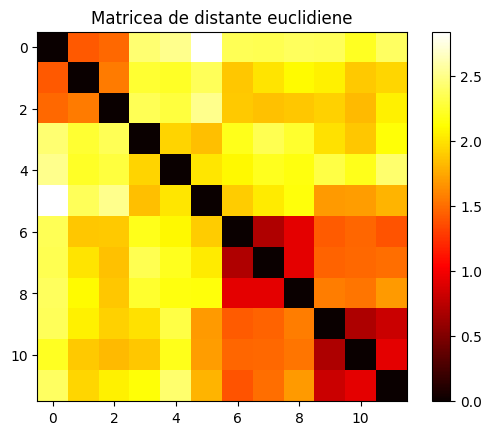

[[ 0  1  2]
 [ 0  1  2]
 [ 0  1  2]
 [ 3  5 10]
 [ 3  4  5]
 [ 5  9 10]
 [ 6  7  8]
 [ 6  7  8]
 [ 6  7  8]
 [ 9 10 11]
 [ 9 10 11]
 [ 9 10 11]]
Nr. fete gasite din 12 =  10
Acuratetea = 83.33333333333334
Rata de clasificare  0.8333333333333334


In [158]:
poze = os.listdir('Lab - 6 HOG/Mari')

descriptori_hog = calc_descriptori_hog_poze(poze, path='Lab - 6 HOG/Mari')

distante = calc_distante_descriptori(descriptori_hog)

# afisez matricea de distante
plt.imshow(distante, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Matricea de distante euclidiene')
plt.show()

nr_fete_corecte = calc_nr_fete_similare_dist(distante)

In [ ]:
# Model 1
# Ex 1
def hog(imagine, tip_nucleu, threshhold):

    #PARAMTERS: imagine,tip_nucleu, threshhold
    #RETURN: GV,GH,histograma gradientilor orientati
    h,w = np.shape(imagine)
    
    # calculul gradientilor Gh si GV in functie de fiecare nucleu
    if(tip_nucleu ==1):
        Gh = -imagine[0:h-1,0:w-1] -2*imagine[0:h-1,1:w] +imagine[1:h,0:w-1] + 2*imagine[1:h,1:w]
        Gv = -imagine[0:h-1,0:w-1]  -2*imagine[1:h,0:w-1] +imagine[0:h-1,1:w] + 2*imagine[1:h,1:w] 
     
    # calcul magnitudine si orientare folosind Gh si Gv
    # puteti folosi math.sqrt si math.atan
    # daca folositi math.atan trebuie sa treceti din [-pi/2,i/2] in [0,pi]
    Mg = np.sqrt(Gh**2 + Gv**2)
    O = np.arctan(Gv/(Gh+0.001)) * (180 / math.pi)
    
    #vectorizare magnitudine si gradienti\
    Mg = Mg.flatten()
    O = O.flatten()

    #anularea orientarilor pentru care magnitudinea este mai mica ca pragul ales
    # altfel spus vreau sa raman in vectorul de orientari doar cu pozitile valorilor
    # pentru care magnitudinea este mai mica decat T
    O[Mg < threshhold] = 1800
    O = O[O != 1800]

    #calculez histograma de orientari pt 9 bins cu np.histogram
    histograma = np.histogram(O, bins=4)[0]
    # print(histograma)

    #normez histograma la suma elementelor si adun si un epsilon ca sa
    #evit situatia in care impart la 0 (blocul contine o regiune uniforma)
    histograma = histograma / (np.sum(histograma) + 1e-5)
  
    return Gh, Gv, histograma

# Ex 2 

def calc_descriptori_hog_poze(poze, path, threshold):

    # poze = os.listdir('Mari')
    descriptori_hog=np.zeros([len(poze),4*4]) # MODIFICAT AICI DUPA MASCA

    for k, poza in enumerate(poze):
        img = io.imread(os.path.join(path, poza))
        img = color.rgb2gray(img)  # Convert to grayscale if needed
        H,W=np.shape(img)
        step = math.ceil(img.shape[0]/3)
        list_hist = []
        
        for i in range(0, H, step):
            for j in range(0, W, step):
                
                i_bloc = i // step
                j_bloc = j // step
                if i_bloc == j_bloc or (i_bloc == 0 and j_bloc == W // step - 1) or (i_bloc == H // step - 1 and j_bloc == 0):
                    continue

                ## sau modificam in masca (0 unde e alb)

                fer = img[i:i+step, j:j+step]
                
                #calculez histograma ferestrei curente si o inmultesc cu masca
                hist_hog = hog(fer,1,threshold)[2]
                hist_norm = hist_hog*mask[i//step,j//step]

                #pun histograma in lista
                list_hist.append(hist_norm)
        
        list_hist = np.array(list_hist)
        descriptori_hog[k,:]=list_hist.flatten()

    return descriptori_hog

poze = os.listdir('Mari_nr_1')
mask = np.array([[1,2,3],
                 [4,5,6],
                 [7,8,9]])
# mask = np.array([[0,2,0],
#                  [4,0,6],
#                  [0,8,0]])
poze = os.listdir('Mari_nr_1')
path='Mari_nr_1'

descriptori_hog = calc_descriptori_hog_poze(poze, path, 0.05)

# afisez matricea de descriptori
print(descriptori_hog)

# Ex 3

def eucdist(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2) ** 2))

def calc_distante_descriptori(descriptori):
    nr_imagini = descriptori.shape[0]
    distante = np.zeros((nr_imagini, nr_imagini))

    for i in range(nr_imagini):
        for j in range(i+1, nr_imagini):
            dist = eucdist(descriptori[i], descriptori[j])
            distante[i, j] = dist
            distante[j, i] = dist

    return distante

def calc_nr_fete_similare_dist(distante):

    nr_fete=0

    calc_fete = np.argsort(distante)
    calc_fete_primele2coloane = np.sort(calc_fete[:,:2])
    print(calc_fete_primele2coloane)

    posibile = ['01','23','45','67']

    for i in range(calc_fete_primele2coloane.shape[0]):
        string = ''
        for j in range(2):
            string+= str(calc_fete_primele2coloane[i,j])
        if string in posibile:
            nr_fete += 1

    print("Nr. fete gasite din 8 = ", nr_fete) 
    print("Acuratetea =", (nr_fete/8)*100)       
    print('Rata de clasificare ',nr_fete/8)

    return nr_fete

def best_prag(thresholds):
    nr_fete_max = 0
    
    for threshold in thresholds:

        poze = os.listdir('Mari_nr_1')
        path='Mari_nr_1'
        descriptori_hog = calc_descriptori_hog_poze(poze, path, threshold)
        distante = calc_distante_descriptori(descriptori_hog)

        nr_fete_corecte = calc_nr_fete_similare_dist(distante)
        if nr_fete_corecte >= nr_fete_max:
            nr_fete_max = nr_fete_corecte
            best_threshold = threshold
    
    return best_threshold, nr_fete_max

best_threshold, nr_fete_max = best_prag([0.05, 0.25, 0.5])
print("Cel mai bun prag este ", best_threshold)
print("Numarul maxim de fete corecte este ", nr_fete_max)

# Ex 4

# În algoritmul Viola-Jones, ponderile exemplelor:

# - Cresc pentru cele clasificate greșit,
# - Scad pentru cele clasificate corect.

# Acest lucru se întâmplă pentru că algoritmul folosește AdaBoost, care pune accent pe exemplele greșite, 
# astfel încât următorii clasificatori să învețe mai bine de la ele și să reducă greșelile.

# Bonus (optional, pentru testare hog)
# verificare pt Sobel 
a=np.array([[100,85,70],
            [81,80,90],
            [92,83,50]])
Gh, Gv = np.zeros((2,2)), np.zeros((2,2))
Gh,Gv,img_hog=hog(a, 1, 0.85)
print(Gh)
print(Gv)

In [ ]:
# (optional, pentru testare hog)
mask=np.array([[2,1,1,1,1,1,2],
    [2,4,4,1,4,4,2],
    [1,1,1,0,1,1,1],
    [0,1,1,0,1,1,0],
    [0,1,1,1,1,1,0],
    [0,1,1,2,1,1,0],
    [0,1,1,1,1,1,0]])

def calc_descriptori_hog_poze(poze, path='Lab - 6 HOG/Mari'):

    # poze = os.listdir('Mari')
    descriptori_hog=np.zeros([len(poze),6*49])

    for k, poza in enumerate(poze):
        img = io.imread(os.path.join(path, poza))
        img = color.rgb2gray(img)  # Convert to grayscale if needed
        H,W=np.shape(img)
        step = math.ceil(img.shape[0]/7)
        list_hist = []
        
        for i in range(0, H, step):
            for j in range(0, W, step):
                
                fer = img[i:i+step, j:j+step]
                
                #calculez histograma ferestrei curente si o inmultesc cu masca
                hist_hog = hog(fer,1,0.05)[2]
                hist_norm = hist_hog*mask[i//step,j//step]

                #pun histograma in lista
                list_hist.append(hist_norm)
        
        list_hist = np.array(list_hist)
        descriptori_hog[k,:]=list_hist.flatten()

    return descriptori_hog

def eucdist(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2) ** 2))

def calc_distante_descriptori(descriptori):
    nr_imagini = descriptori.shape[0]
    distante = np.zeros((nr_imagini, nr_imagini))

    for i in range(nr_imagini):
        for j in range(i+1, nr_imagini):
            dist = eucdist(descriptori[i], descriptori[j])
            distante[i, j] = dist
            distante[j, i] = dist

    return distante

def calc_nr_fete_similare_dist(distante):

    nr_fete=0

    calc_fete = np.argsort(distante)
    calc_fete_primele3coloane = np.sort(calc_fete[:,:3])
    print(calc_fete_primele3coloane)

    posibile = ['012','345','678','91011']

    for i in range(calc_fete_primele3coloane.shape[0]):
        string = ''
        for j in range(3):
            string+= str(calc_fete_primele3coloane[i,j])
        if string in posibile:
            nr_fete += 1

    print("Nr. fete gasite din 12 = ", nr_fete) 
    print("Acuratetea =", (nr_fete/12)*100)       
    print('Rata de clasificare ',nr_fete/12)

    return nr_fete

poze = os.listdir('Lab - 6 HOG/Mari')

descriptori_hog = calc_descriptori_hog_poze(poze, path='Lab - 6 HOG/Mari')

distante = calc_distante_descriptori(descriptori_hog)

# afisez matricea de distante
plt.imshow(distante, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Matricea de distante euclidiene')
plt.show()

nr_fete_corecte = calc_nr_fete_similare_dist(distante)

In [ ]:
# Model 2

# Ex 1

def hog(imagine, tip_nucleu, threshhold):

    #PARAMTERS: imagine,tip_nucleu, threshhold
    #RETURN: GV,GH,histograma gradientilor orientati
    h,w = np.shape(imagine)
    
    # calculul gradientilor Gh si GV in functie de fiecare nucleu
    if(tip_nucleu ==1):
        Gh = 2*imagine[0:h-1,0:w-1] - 2*imagine[0:h-1,1:w] + 4*imagine[1:h,0:w-1] - 4*imagine[1:h,1:w]
        Gv = 2*imagine[0:h-1,0:w-1] - 2*imagine[1:h,0:w-1] + 4*imagine[0:h-1,1:w] - 4*imagine[1:h,1:w] 

        # Gh = 2*imagine[0:h-1,0:w-1] - 2*imagine[1:h,0:w-1] + 4*imagine[0:h-1,1:w] - 4*imagine[1:h,1:w]
        # Gv = 2*imagine[0:h-1,0:w-1] - 2*imagine[0:h-1,1:w] + 4*imagine[1:h,0:w-1] - 4*imagine[1:h,1:w]
    
    # calcul magnitudine si orientare folosind Gh si Gv
    # puteti folosi math.sqrt si math.atan
    # daca folositi math.atan trebuie sa treceti din [-pi/2,i/2] in [0,pi]
    Mg = np.sqrt(Gh**2 + Gv**2)
    O = np.arctan(Gv/(Gh+0.001)) * (180 / math.pi)
    
    #vectorizare magnitudine si gradienti\
    Mg = Mg.flatten()
    O = O.flatten()

    #anularea orientarilor pentru care magnitudinea este mai mica ca pragul ales
    # altfel spus vreau sa raman in vectorul de orientari doar cu pozitile valorilor
    # pentru care magnitudinea este mai mica decat T
    O[Mg < threshhold] = 1800
    O = O[O != 1800]

    #calculez histograma de orientari pt 9 bins cu np.histogram
    histograma = np.histogram(O, bins=6)[0]
    # print(histograma)

    #normez histograma la suma elementelor si adun si un epsilon ca sa
    #evit situatia in care impart la 0 (blocul contine o regiune uniforma)
    histograma = histograma / (np.sum(histograma) + 1e-5)
  
    return Gh, Gv, histograma

# Ex 2

def eucdist(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2) ** 2))

def calc_distante_descriptori(descriptori):
    nr_imagini = descriptori.shape[0]
    distante = np.zeros((nr_imagini, nr_imagini))

    for i in range(nr_imagini):
        for j in range(i+1, nr_imagini):
            dist = eucdist(descriptori[i], descriptori[j])
            distante[i, j] = dist
            distante[j, i] = dist

    return distante

def calc_descriptori_hog_poze(poze, path, threshold):

    # poze = os.listdir('Mari')
    descriptori_hog=np.zeros([len(poze),6*2])

    for k, poza in enumerate(poze):
        img = io.imread(os.path.join(path, poza))
        img = color.rgb2gray(img)  # Convert to grayscale if needed
        H,W=np.shape(img)
        step = math.ceil(img.shape[0]/3)
        list_hist = []
        
        for i in range(0, H, step):
            for j in range(0, W, step):

                i_bloc = i // step
                j_bloc = j // step
                if ((i_bloc != 0 and j_bloc == 0) or (i_bloc != 0 and j_bloc == W//step - 1)) or (mask[i_bloc,j_bloc]%2 != 0):
                    continue
                
                print("am ales blocul, ",i_bloc,j_bloc, " pentru poza ",k)
                
                fer = img[i:i+step, j:j+step]
                
                #calculez histograma ferestrei curente si o inmultesc cu masca
                hist_hog = hog(fer,1,threshold)[2]
                hist_norm = hist_hog*mask[i//step,j//step]

                #pun histograma in lista
                list_hist.append(hist_norm)
        
        list_hist = np.array(list_hist)
        descriptori_hog[k,:]=list_hist.flatten()

    return descriptori_hog

poze = os.listdir('Mari_nr_2')
mask = np.array([[8,3,9],
                 [1,4,2],
                 [6,5,7]])
poze = os.listdir('Mari_nr_2')
path='Mari_nr_2'

descriptori_hog = calc_descriptori_hog_poze(poze, path, 0.05)

# afisez matricea de descriptori
print(descriptori_hog)

# Ex 3

def calc_nr_fete_similare_dist(distante):

    nr_fete=0

    calc_fete = np.argsort(distante)
    calc_fete_primele3coloane = np.sort(calc_fete[:,:4])
    print(calc_fete_primele3coloane)

    posibile = ['0123','4567','891011','12131415']

    for i in range(calc_fete_primele3coloane.shape[0]):
        string = ''
        for j in range(4):
            string+= str(calc_fete_primele3coloane[i,j])
        if string in posibile:
            nr_fete += 1

    print("Nr. fete gasite din 16 = ", nr_fete) 
    print("Acuratetea =", (nr_fete/16)*100)       
    print('Rata de clasificare ',nr_fete/16)

    return nr_fete

def best_prag(thresholds):
    nr_fete_max = 0
    
    for threshold in thresholds:

        poze = os.listdir('Mari_nr_2')
        path='Mari_nr_2'
        descriptori_hog = calc_descriptori_hog_poze(poze, path, threshold)
        distante = calc_distante_descriptori(descriptori_hog)

        nr_fete_corecte = calc_nr_fete_similare_dist(distante)
        if nr_fete_corecte >= nr_fete_max:
            nr_fete_max = nr_fete_corecte
            best_threshold = threshold
    
    return best_threshold, nr_fete_max

best_threshold, nr_fete_max = best_prag([0.1, 0.3, 0.6])
print("Cel mai bun prag este ", best_threshold)
print("Numarul maxim de fete corecte este ", nr_fete_max)

# pt 8 poze (2 cate 2 la fel)

#initializez matrica de distante    
distante=np.zeros([8,8])

#calculez dist euclidiana intre toti descritorii asociati imaginilor
#inclusiv intre aceeasi descriptori
for k in range(distante.shape[0]):
    for l in range(distante.shape[1]):
        distante[k,l]=eucdist(descriptori_hog[k],descriptori_hog[l])


nr_fete=0

# np.sort - ordoneaza crescator valorile
# np.argsort - ordoneaza indicii in ordinea crescatoare a valorilor efective coresp. fiecarui indice
#prin aceasta metoda, vom obtine in matrice, pe primele 2 coloane, indicii distantelor celor mai mici pt poza respectiva
calc_fete = np.argsort(distante)

#stim ca in folder avem cate 2 poze pt fiecare poza, ordonate: 2xP1, 2xP2, 2xP3, 2xP4
# => pt poza P1 vrem sa obtinem indicii 0,1 (coresp primelor 2 imagini din folder)
#sortam primele 2 coloane pt a obtine mereu indicii in ord 
calc_fete = np.sort(calc_fete[:,:2])
print(calc_fete)
posibile = ['01','23','45','67']

for i in range(calc_fete.shape[0]):
    string = ''
    for j in range(2):
        string+= str(calc_fete[i,j])
    if string in posibile:
        nr_fete += 1
        
        
print('Nr de fete este ', nr_fete)

# Ex 4 (intrebare)

# Ce este imaginea integrala? De ce avem nevoie de ea?
# Imaginea integrala reprezinta o matrice ce contine suma cumulativa pe linii, apoi pe coloane (utilizand rezultatul de la linii).
# Astfel, primul element al matricei II va fi egal cu primul element al imaginii initiale, iar ultimul va contine suma tuturor valorilor din imaginea initiala.
# Folosim II pentru a calcula suma intensitatilor luminoase (suma pixelilor) din anumite regiuni specifice din imagine, deoarece in coltul din dreapta jos vom avea intotdeauna suma tuturor intensitatilor dintr-o imagine.

# Ne ajuta sa calculam rapid anumite caracteristici din imagine fara sa facem aceleasi operatii iar si iar

# Bonus (optional, pentru testare hog)
# verificare pt Sobel 
a=np.array([[100,85,70],
            [81,80,90],
            [92,83,50]])
Gh, Gv = np.zeros((2,2)), np.zeros((2,2))
Gh,Gv,img_hog=hog(a, 1, 0.85)
print(Gh)
print(Gv)